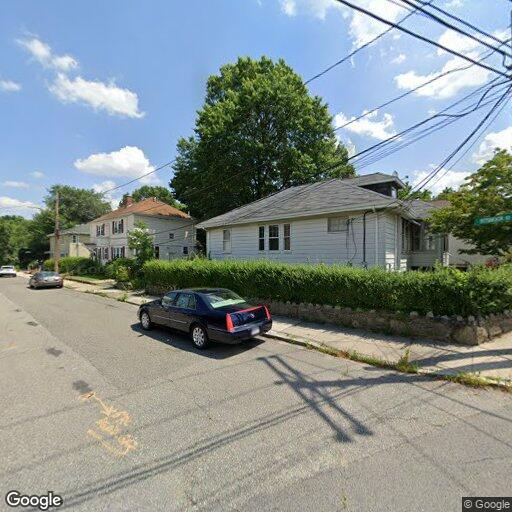

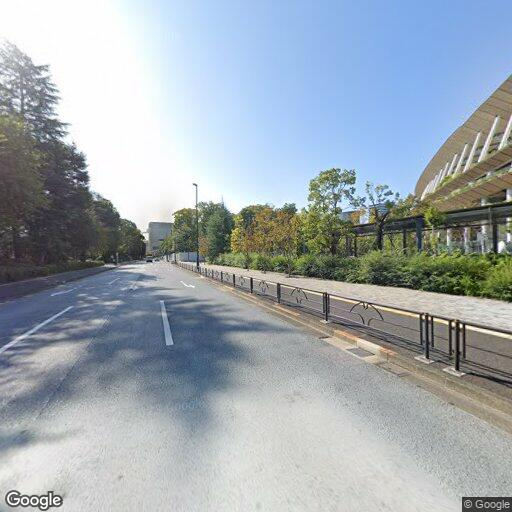

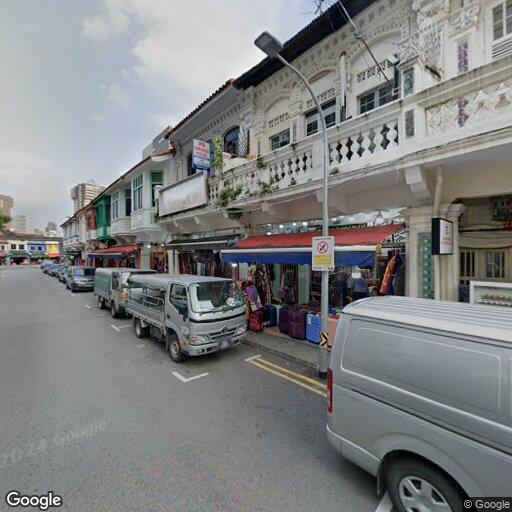

In [2]:
# --- Configuration ---
# Adjust these paths for your environment
QA_PATH = "./eval/qa_dataset_5.0.0_train_small.json"      # JSON or JSONL
META_PATH = "./data/final_dataset_2.0.0.json"            # JSON (list of dicts)
IMG_ROOT = "./eval/images_v3_50k"                           # directory containing the actual images

# --- Utilities to load QA (json or jsonl) ---
import json

def load_qa_entries(path):
    # Try JSONL first
    entries = []
    with open(path, "r", encoding="utf-8") as f:
        first = f.read(1024)
        f.seek(0)
        if first.strip().startswith("["):
            # JSON array
            entries = json.load(f)
        else:
            # JSONL (one JSON object per line)
            for line in f:
                line = line.strip()
                if not line: 
                    continue
                entries.append(json.loads(line))
    return entries

qa_entries = load_qa_entries(QA_PATH)
len(qa_entries), qa_entries[0] if qa_entries else None

# --- Load metadata ---
with open(META_PATH, "r", encoding="utf-8") as f:
    meta_entries = json.load(f)

# Build lookup dicts by image_id
# Metadata image_id typically has no '.jpg' suffix; QA has the filename (with '.jpg').
meta_by_noext = {m.get("image_id"): m for m in meta_entries}
meta_by_withjpg = {f"{m.get('image_id')}.jpg": m for m in meta_entries}

def find_meta(image_id_from_qa):
    # Try exact match with '.jpg', then try stripping extension
    meta = meta_by_withjpg.get(image_id_from_qa)
    if meta is not None:
        return meta
    key = image_id_from_qa
    if key.endswith(".jpg"):
        key = key[:-4]
    return meta_by_noext.get(key)

# Quick sanity check
sample = qa_entries[0]["image_id"] if qa_entries else ""
find_meta(sample) if sample else None

# --- Display helpers ---
from IPython.display import display, Image, HTML
from pathlib import Path
import pprint

def json_pretty(obj):
    try:
        return json.dumps(obj, indent=2, ensure_ascii=False)
    except Exception:
        return str(obj)

def display_entry(i):
    if i < 0 or i >= len(qa_entries):
        display(HTML(f"<b>Index {i} out of range [0, {len(qa_entries)-1}]</b>"))
        return
    
    e = qa_entries[i]
    image_id = e.get("image_id")
    question = e.get("question")
    answer = e.get("answer")
    subtype = e.get("subtype")
    cot_answer = e.get("cot_answer")
    
    meta = find_meta(image_id)
    
    # Image path (from QA image_id)
    img_path = Path(IMG_ROOT) / image_id
    img_exists = img_path.exists()
    
    display(HTML(f"<hr><h3>Index: {i}</h3><b>image_id:</b> {image_id}<br>"
                 f"<b>subtype:</b> {subtype}<br>"
                 f"<b>question:</b> {question}<br>"
                 f"<b>answer:</b> {answer}</p>"))
    
    if img_exists:
        display(Image(filename=str(img_path), width=200))
    else:
        display(HTML(f"<i>Image not found at: {img_path}</i>"))
    
    display(HTML("<h4>CoT Answer</h4>"))
    display(HTML(f"<pre style='white-space:pre-wrap'>{cot_answer}</pre>"))
    
    display(HTML("<h4>Metadata</h4>"))
    if meta is not None:
        # Pretty JSON-like view
        display(HTML(f"<pre>{json_pretty(meta)}</pre>"))
    else:
        display(HTML("<i>No metadata found for this image_id.</i>"))

# Show the first few examples
for i in range(min(3, len(qa_entries))):
    display_entry(i)

In [10]:
from IPython.display import HTML
from pathlib import Path

IMG_WIDTH = 280  # tweak as you like
_STYLES_INJECTED = False

def ensure_styles():
    global _STYLES_INJECTED
    if _STYLES_INJECTED:
        return
    _STYLES_INJECTED = True
    style = """
    <style>
      .qa-card pre {
            background: #f8fafc;
            padding: 10px;
            border-radius: 8px;
            overflow: auto;
            color: #000000;  /* <-- force black text */
            font-weight: 400;
        }
      .qa-card { border:1px solid #e5e7eb; border-radius:12px; padding:12px; margin:16px 0; }
      .qa-row { display:flex; gap:16px; align-items:flex-start; }
      .qa-left { flex: 0 0 auto; }
      .qa-left img { display:block; max-width:100%; height:auto; border-radius:8px; }
      .qa-right { flex: 1 1 auto; min-width: 0; }
      .qa-meta pre { background:#f8fafc; padding:10px; border-radius:8px; overflow:auto; }
      .qa-title { margin:0 0 8px 0; }
      @media (max-width: 800px){
        .qa-row { flex-direction: column; }
      }
    </style>
    """
    display(HTML(style))

def display_entry(i):
    ensure_styles()
    if i < 0 or i >= len(qa_entries):
        display(HTML(f"<b>Index {i} out of range [0, {len(qa_entries)-1}]</b>"))
        return
    
    e = qa_entries[i]
    image_id = e.get("image_id")
    question = e.get("question")
    answer = e.get("answer")
    subtype = e.get("subtype")
    cot_answer = e.get("cot_answer")
    meta = find_meta(image_id)

    img_path = Path(IMG_ROOT) / image_id
    img_exists = img_path.exists()
    img_src = img_path.as_posix()

    # Build right-side HTML
    right_html = f"""
      <h3 class="qa-title">#{i} — {image_id}</h3>
      <div><b>Subtype:</b> {subtype or ''}</div>
      <div><b>Question:</b> {question or ''}</div>
      <div><b>Answer:</b> {answer or ''}</div>
      <h4>CoT Answer</h4>
      <pre style="white-space:pre-wrap">{cot_answer or ''}</pre>
      <h4>Metadata</h4>
      {"<pre>" + json_pretty(meta) + "</pre>" if meta is not None else "<i>No metadata found for this image_id.</i>"}
    """

    # Full card with image on the left, text on the right
    html = f"""
    <div class="qa-card">
      <div class="qa-row">
        <div class="qa-left">
          {"<img src='" + img_src + f"' width='{IMG_WIDTH}'>" if img_exists else f"<i>Image not found at: {img_src}</i>"}
        </div>
        <div class="qa-right qa-meta">
          {right_html}
        </div>
      </div>
    </div>
    """
    display(HTML(html))

display_entry(60)